# 1. Imports

### 1.1 Libraries

In [ ]:
# -*- coding: utf-8 -*-
# Standard Libraries --------------------------------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import requests
import subprocess
import os
from os import listdir
from os.path import isfile, join
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Sklearn --------------------------------------------------------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE


# Librosa --------------------------------------------------------------------------------------------------------------------------------------
import librosa
import librosa.display


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### 1.2 Data

In [ ]:
data_path = "/Users/divya/Desktop/GV_work_dir/sample.xlsx"

In [ ]:
# -----------------------------------------------------------------------------------------------------------------
audio_excel_path_1 = '/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/noise_classifier_2000_new.xlsx'

# audio_excel_path_2 = '/content/drive/MyDrive/Gram_Vaani/Noise_classifier/noisy_classifier_200.xlsx'

# Reading the excel file with audio links ---------------------------------------------------------------
# data = pd.concat([pd.read_excel(audio_excel_path_1), pd.read_excel(audio_excel_path_2)])
data = pd.read_excel(audio_excel_path_1)
# Divinding clean and noisy data for extraction ---------------------------------------------------------
noise_data = data[data['Accept/Noisy label']==1].copy()
clean_data = data[data['Accept/Noisy label']==0].copy()
print ("Shape of noisy data is: ", str(noise_data.shape), " And Shape of clean data is: ", str(clean_data.shape))
# -----------------------------------------------------------------------------------------------------------------

Shape of noisy data is:  (1000, 12)  And Shape of clean data is:  (1000, 12)


# 2. Functions 

### 2.1 Download audio files

In [ ]:
# Function to download audio files and extract spectrogram features ---------------------------------------------------------------------------
error_files = []
def download_audios(aud_type, noisy_str):
    """
    aud_type - DataFrame of clean and noisy data
    noisy_str - output_folder path for clean and noisy data
    """
    # Iterating over URLs in the excel file -----------------------------------------------------------------
    for url in tqdm(aud_type['Recording audio link']):
      
        try:
            # Reading URLs and saving audio files, spectrograms in an output directory 
            url_id = url[(url.rindex('/')+1):-4]
            audio = requests.get(url)
            # Output path, separate for noisy and clean audio ----------------------------------------------- 
            path = "/Users/divya/Desktop/GV_work_dir/raw_audio/wave_files_{}/".format(noisy_str)
            # ------------------------------------------------------------------------------------------------
            # Audio Download ---------------------------------------------------------------------------------
            if not os.path.exists(path):
                os.makedirs(path)
            filename = path+url_id + ".mp3"
            # filename_wave = path+url_id+".wav"           
            # file1 = open(filename, 'wb')
            # file1.write(audio.content)
            subprocess.call(['ffmpeg', '-i',filename,filename_wave],stdout=subprocess.DEVNULL,stderr=subprocess.STDOUT)
            os.remove(filename)
            # ------------------------------------------------------------------------------------------------

        except Exception as e:
            print("Error: {}".format(str(e)))
            error_files.append(str(url))

In [ ]:
download_audios(clean_data, "clean_data")

100%|██████████| 1000/1000 [28:32<00:00,  1.71s/it]


In [ ]:
download_audios(noise_data, "noisy_data")

100%|██████████| 1000/1000 [42:28<00:00,  2.55s/it]


### 2.2 Feature Extraction

In [ ]:
# Extracting features from audio files  ----------------------------------------------------------------------
# df contains path of each audio file as path/audio_name.mp3 -------------------

def get_features(df):
  # Creating separate DFs for appending file names and labels ------------------
  file_list = list(df.iloc[:,0])
  label_list = list(df.iloc[:,1])
  name = pd.DataFrame(columns=['file_name'])

  # Iterating over all the audio paths -----------------------------------------
  for i in tqdm(range(df.shape[0])):

    try:
      # for each audio file ----------------------------------------
      data = pd.DataFrame(columns=['feature'])
      label = pd.DataFrame(columns=['label'])
      # Read audio -------------------------------------------------
      x, sample_rate = librosa.load(file_list[i])
      # Numpy array that will store all the features ---------------
      result=np.array([])
      
      # MFCCs Mean ------------------------------------------------
      mfccs = librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T
      mfccs_mean = np.mean(mfccs, axis=0)
      result=np.hstack((result, mfccs_mean))

      ## MFCCs Variance --------------------------------------------
      # mfccs_var = np.var(mfccs, axis=0)
      # result=np.hstack((result, mfccs_var))
      
      # Chroma ----------------------------------------------------
      stft=np.abs(librosa.stft(x))
      chroma=np.mean(librosa.feature.chroma_stft(x, sr=sample_rate).T,axis=0)
      result=np.hstack((result, chroma))

      # Mel Spectrogram Features -----------------------------------
      mel=np.mean(librosa.feature.melspectrogram(x, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))

      ## Zero Crossings -------------------------------------------
      # zero_crossings = sum(librosa.zero_crossings(x, pad=False))
      # result=np.hstack((result, zero_crossings))

      ## Mean RMS -------------------------------------------------
      # rms = np.mean(librosa.feature.rms(x))
      # result=np.hstack((result, rms))

      ## Spectral Centroid ----------------------------------------
      # sc = np.mean(librosa.feature.spectral_centroid(x))
      # result=np.hstack((result, sc))

      ## Spectral Rolloff -----------------------------------------
      # spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(x))
      # result=np.hstack((result, spectral_rolloff))

      ## Harmonics and Perceptrual --------------------------------
      # y_harm, y_perc = librosa.effects.hpss(x)
      # y_harm = np.mean(y_harm)
      # y_perc = np.mean(y_perc)
      # result=np.hstack((result, y_harm))
      # result=np.hstack((result, y_perc))
      # ------------------------------------------------------------

      # Label, filename and features -------------------------------
      label.at[i,'label'] = label_list[i]
      data.loc[i] = [result]
      name.at[i,'file_name'] = file_list[i].split('/')[-1]
      # -------------------------------------------------------------
    except:
      print ("File Not Downloadable: ",str(i))
    # --------------------------------------------------------------------------
    # Creating a temp data for each audio --------------------------------------

    temp_data = pd.DataFrame(data['feature'].values.tolist())
    temp_data['file_name'] = file_list[i].split('/')[-1]
    temp_data['label'] = label_list[i]
    # --------------------------------------------------------------------------
    # Appending results to a final_data ----------------------------------------
    if i == 0:
      # Creating final data on 0th iteration -----------------------------------
      final_data = pd.DataFrame(columns = list(temp_data))
      # ------------------------------------------------------------------------
    # Appending data 1st iteration onwards -------------------------------------
    final_data = pd.concat([temp_data,final_data])
    # --------------------------------------------------------------------------
  return final_data
# ------------------------------------------------------------------------------------------------------------

# 3. Main

### 3.1 Downloading audios

### 3.2 DF of all audio file paths 

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------
# Path of noisy and clean audio files -------------------------------------------------------------------------
path_noisy = '/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/wave_files_noisy_data/'
path_clean = '/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/wave_files_clean_data/'

# Noisy files --------------------------------------------------------------------------------------------------
df_noisy = pd.DataFrame([f for f in listdir(path_noisy) if isfile(join(path_noisy, f))], columns = ['file_name'])
df_noisy['file_name'] = df_noisy['file_name'].apply(lambda x:path_noisy+x)
df_noisy['label'] = 1
# ---------------------------------------------------------------------------------------------------------------
# Clean files ---------------------------------------------------------------------------------------------------
df_clean = pd.DataFrame([f for f in listdir(path_clean) if isfile(join(path_clean, f))], columns = ['file_name'])
df_clean['file_name'] = df_clean['file_name'].apply(lambda x:path_clean+x)
df_clean['label'] = 0
# ---------------------------------------------------------------------------------------------------------------
# Single df for noisy and clean files ---------------------------------------------------------------------------
df = pd.concat([df_noisy,df_clean])
# ----------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# df["ext"] = df["file_name"].apply(lambda x:x.split('.')[1])
# df["file_name"] = df["file_name"].apply(lambda x:x.split('.')[0])
# df["ext"] = df["file_name"].apply(lambda x:x.split('.')[1])
# df["ext"].value_counts()

1995

### 3.3 Extracting features

In [ ]:
df_features =  get_features(df.copy())
# df_features_new.to_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/final_part_8.csv", index = False)

Reading files after first download

In [ ]:
df_features = pd.concat([pd.read_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/tushar_data_features.csv"), pd.read_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/final_part_7.csv"), pd.read_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/final_part_6.csv"), pd.read_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/final_part_5.csv")])
df_features["file_name"] = df_features["file_name"].apply(lambda x:x.split(".")[0])
df_features.drop_duplicates(inplace = True)
df_features.shape

(2990, 182)

2021 data

In [ ]:
df_features_new = pd.read_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/final_part_8.csv")
df_features_new["file_name"] = df_features_new["file_name"].apply(lambda x:x.split(".")[0])
df_features_new.drop_duplicates(inplace = True)
df_features_new.shape

(1675, 182)

#### 3.3.1 Correlation Matrix

In [ ]:
# Correlation matrix ----------------------------------------------------------------------------------------------------------------
corr = df_features.corr()
corr.style.background_gradient(cmap='coolwarm')
# -----------------------------------------------------------------------------------------------------------------------------------

# 4. Data Modeling 

In [ ]:
df_features["file_name"] = df_features["file_name"].apply(lambda x: x.split(".")[0])
df_features.drop_duplicates(inplace = True)

In [ ]:
df_features["file_name"].nunique()

2990

--- df_features_new

In [ ]:
# df_features_new = pd.read_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/final_part_8.csv")
df_features_new["file_name"] = df_features_new["file_name"].apply(lambda x: x.split(".")[0])
df_features_new.drop_duplicates(inplace = True)

In [ ]:
df_features_new.shape

(1675, 182)

### 4.1 Train data

In [ ]:
# # Features ---------------------------------------------------------------------------------------------------------------------------
# df_model = df_features.copy()
# y = np.array(df_model['label'])
# df_model= df_model.drop(['label','file_name'], axis = 1)
# # Feature Columns --------------------------------------------------------------
# # 180 = 40 (MFCC) + 12 (Chroma) + 128 (Mel Spectrogram) ------------------------
# cols_list = list(df_model.columns)
# X = np.array(df_model)
# # --------------------------------------------------------------------------------------------------------------------------------------
# # Labels -------------------------------------------------------------------------------------------------------------------------------
# y=y.astype('int')
# # 25% test split -----------------------------------------------------------------------------
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
# # --------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
train, test = train_test_split(df_features_new, test_size=0.2)
df_features = pd.concat([train, df_features])
df_features.drop_duplicates(inplace = True)
df_features.shape

(4330, 182)

In [ ]:
# Features ---------------------------------------------------------------------------------------------------------------------------
df_model = df_features.copy()
y = np.array(df_model['label'])
df_model= df_model.drop(['label','file_name'], axis = 1)
# Feature Columns --------------------------------------------------------------
# 180 = 40 (MFCC) + 12 (Chroma) + 128 (Mel Spectrogram) ------------------------
cols_list = list(df_model.columns)
X_train = np.array(df_model)
# --------------------------------------------------------------------------------------------------------------------------------------
# Labels -------------------------------------------------------------------------------------------------------------------------------
y_train=y.astype('int')
# 25% test split -----------------------------------------------------------------------------
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
# --------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
print (X_train.shape)

(4330, 180)


In [ ]:
print (y_train.shape)

(4330,)


#### 4.1.1 Train Data - T-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3827 samples in 0.070s...
[t-SNE] Computed neighbors for 3827 samples in 3.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3827
[t-SNE] Computed conditional probabilities for sample 2000 / 3827
[t-SNE] Computed conditional probabilities for sample 3000 / 3827
[t-SNE] Computed conditional probabilities for sample 3827 / 3827
[t-SNE] Mean sigma: 14.446821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.107437
[t-SNE] KL divergence after 2000 iterations: 1.231431


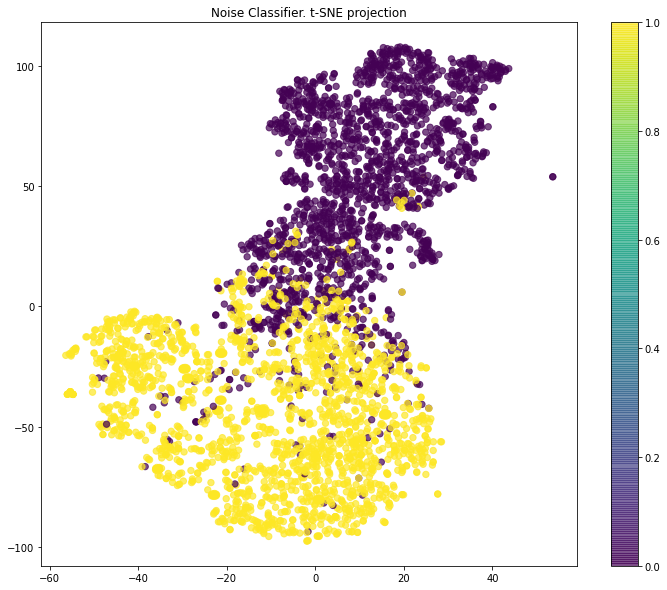

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000,random_state = 17)
df_tsne_scaled = tsne.fit_transform(X_train)
plt.figure(figsize=(12,10))

plt.scatter(df_tsne_scaled[:, 0], df_tsne_scaled[:, 1], c=df_features['label'], 
            alpha=0.7, s=40)
plt.colorbar()
plt.title('Noise Classifier. t-SNE projection');

### 4.2 Test Data

In [ ]:
# Features ---------------------------------------------------------------------------------------------------------------------------
df_model = df_features_new.copy()
y = np.array(df_features_new['label'])

# df_model = test.copy()
# y = np.array(test['label'])

df_model= df_model.drop(['label','file_name'], axis = 1)
# Feature Columns --------------------------------------------------------------
# 180 = 40 (MFCC) + 12 (Chroma) + 128 (Mel Spectrogram) ------------------------
cols_list = list(df_model.columns)
X_test = np.array(df_model)
# --------------------------------------------------------------------------------------------------------------------------------------
# Labels -------------------------------------------------------------------------------------------------------------------------------
y_test=y.astype('int')
# 25% test split -----------------------------------------------------------------------------
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
# --------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
print (X_test.shape)
print (y_test.shape)

(1675, 180)
(1675,)


#### Test Data - 4.2.1 T-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 838 samples in 0.011s...
[t-SNE] Computed neighbors for 838 samples in 0.202s...
[t-SNE] Computed conditional probabilities for sample 838 / 838
[t-SNE] Mean sigma: 26.879915
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.177013
[t-SNE] KL divergence after 2000 iterations: 0.652722


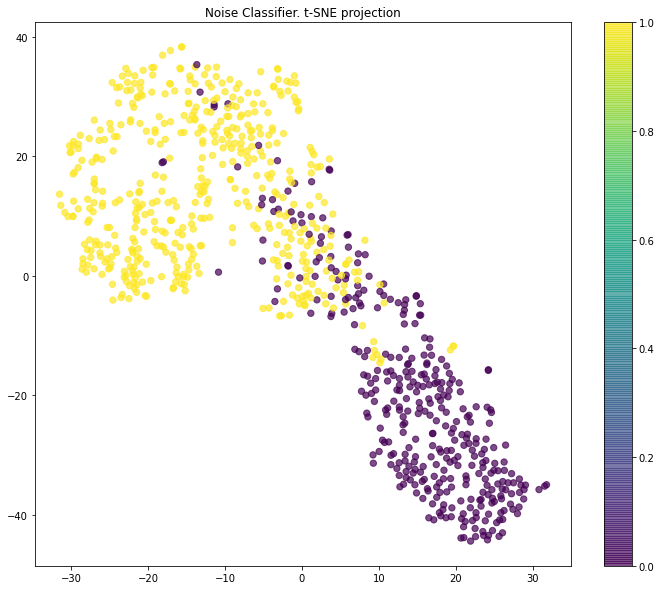

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000,random_state = 17)
df_tsne_scaled = tsne.fit_transform(X_test)
plt.figure(figsize=(12,10))

plt.scatter(df_tsne_scaled[:, 0], df_tsne_scaled[:, 1], c=test['label'], 
            alpha=0.7, s=40)
plt.colorbar()
plt.title('Noise Classifier. t-SNE projection');

### 4.3 RandomForest 

##### 4.11 HyperParameter Tuning, Randomized CV 

In [ ]:
# ---------------------------------------------------------------------------------------------------------------------------------------
# Number (trees) ---------------------------------------------------------------
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split --------------------------------
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree ---------------------------------------------
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node ---------------------------
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node -------------------------
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree ---------------------------
bootstrap = [True, False]
# Create the random grid -------------------------------------------------------
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# ---------------------------------------------------------------------------------------------------------------------------------------

##### 4.12 Fitting and Best Model  

In [ ]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

In [ ]:
# ---------------------------------------------------------------------------------------------------------------------------------------
rf = RandomForestClassifier()
# 3Fold Cross Validation -------------------------------------------------------
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
# ---------------------------------------------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 62.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 112.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

##### 4.13 Best Model

Classification Report

In [ ]:
# Classification report -------------------------------------------------------------------------------------------------------------------
# rf_tuned = rf_random.best_estimator_
preds = rf_tuned.predict(X_test)
classification_report(y_test,preds, output_dict=True)
# ---------------------------------------------------------------------------------------------------------------------------------------

{'0': {'f1-score': 0.9571532316630357,
  'precision': 0.9835820895522388,
  'recall': 0.9321074964639321,
  'support': 707},
 '1': {'f1-score': 0.9700963000506841,
  'precision': 0.9522388059701492,
  'recall': 0.9886363636363636,
  'support': 968},
 'accuracy': 0.964776119402985,
 'macro avg': {'f1-score': 0.96362476585686,
  'precision': 0.967910447761194,
  'recall': 0.9603719300501479,
  'support': 1675},
 'weighted avg': {'f1-score': 0.9646331661103453,
  'precision': 0.9654684785030073,
  'recall': 0.964776119402985,
  'support': 1675}}

In [ ]:
test["preds"] = preds
# df_features_new["preds"] = preds

confusion_matrix(y, preds)

array([[659,  48],
       [ 11, 957]])

In [ ]:
test.to_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/2021_50_per_data_preds_model_20.csv",index = False)

Wrong perdiction audio analysis

In [ ]:
preds = pd.read_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/2021_50_per_data_preds.csv")

In [ ]:
wrong_preds = preds[preds["label"]!=preds["preds"]].copy()
wrong_preds["file_name"] = wrong_preds["file_name"].apply(lambda x: str(x))
print (wrong_preds.shape)

data["file_name"] = data["Recording audio link"].apply(lambda x: x.split("/")[-1])
data["file_name"] = data["file_name"].apply(lambda x: x.split(".")[0])
data["file_name"] = data["file_name"].apply(lambda x: str(x))
wrong_pred_files = data.merge(wrong_preds[["file_name","preds","label"]], on = "file_name", how = "inner")

(58, 183)


In [ ]:
print (wrong_pred_files.shape)

(58, 15)


In [ ]:
wrong_pred_files.to_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/wrong_preds_2021_50_per_data_preds.csv")

Temporary testing

In [ ]:
import pickle
model_path = '/content/drive/MyDrive/Gram_Vaani/Noise_classifier/Models/'
rf_tuned = pickle.load(open(model_path+"tuned_rf_2020_21_data.pkl", 'rb'))

Prediction Report for Feb 2021 Data 

In [ ]:
# Classification report -------------------------------------------------------------------------------------------------------------------
# rf_tuned = rf_random.best_estimator_
preds = rf_tuned.predict(X_test)
classification_report(y,preds, output_dict=True)
# ---------------------------------------------------------------------------------------------------------------------------------------

{'0': {'f1-score': 0.9602831301612268,
  'precision': 0.9815112540192926,
  'recall': 0.9399538106235565,
  'support': 1299},
 '1': {'f1-score': 0.9616989002654531,
  'precision': 0.9420505200594353,
  'recall': 0.9821843532145623,
  'support': 1291},
 'accuracy': 0.961003861003861,
 'macro avg': {'f1-score': 0.96099101521334,
  'precision': 0.961780887039364,
  'recall': 0.9610690819190595,
  'support': 2590},
 'weighted avg': {'f1-score': 0.9609888286958046,
  'precision': 0.9618418302578348,
  'recall': 0.961003861003861,
  'support': 2590}}

Prediction Report New Data

In [ ]:
# Classification report -------------------------------------------------------------------------------------------------------------------
# rf_tuned = rf_random.best_estimator_
preds = rf_tuned.predict(X_test)
classification_report(y,preds, output_dict=True)
# ---------------------------------------------------------------------------------------------------------------------------------------

{'0': {'f1-score': 0.9550072568940494,
  'precision': 0.982089552238806,
  'recall': 0.9293785310734464,
  'support': 354},
 '1': {'f1-score': 0.9685916919959474,
  'precision': 0.9502982107355865,
  'recall': 0.987603305785124,
  'support': 484},
 'accuracy': 0.9630071599045346,
 'macro avg': {'f1-score': 0.9617994744449985,
  'precision': 0.9661938814871962,
  'recall': 0.9584909184292851,
  'support': 838},
 'weighted avg': {'f1-score': 0.9628531597452651,
  'precision': 0.9637279659768034,
  'recall': 0.9630071599045346,
  'support': 838}}

In [ ]:
confusion_matrix(y, preds)

array([[303,  48],
       [ 11, 476]])

##### 1.1 Post Prediction Analysis

Appending preds to the original data file for analysis

In [ ]:
# Concatenating labels to the original data -------------------------------------------------------------------------------------------------
# Handling duplicate files due to .mp3 .wav of same file name -------------------- 
data["file_name"] = data["Recording audio link"].apply(lambda x:x.split("/")[-1])
data["file_name"] = data["file_name"].apply(lambda x:x.split(".")[0])

# Handled Above ------------------------------------------------------------------
# data["file_name"] = data["file_name"].apply(lambda x:x.split(".")[0])
# ---------------------------------------------------------------------------------
df_features["preds"] = preds
df_features["file_name"] = df_features["file_name"].apply(lambda x:x.split(".")[0])
post_pred_analysis = data.merge(df_features[["file_name","label","preds"]], on = "file_name", how = "left")
post_pred_analysis.to_csv("/content/drive/MyDrive/Gram_Vaani/Noise_classifier/data/post_pred_analysis_new_data.csv",index = False)
# ------------------------------------------------------------------------------------------------------------------------------------------
# Biforcating error and non-error files for pivoting to see state wise distribution of FP and FN -------------------------------------------
errors = post_pred_analysis[post_pred_analysis["preds"]!=post_pred_analysis["label"]].copy()
non_errors = post_pred_analysis[post_pred_analysis["preds"]==post_pred_analysis["label"]].copy()
errors = errors[~(errors["preds"].isnull())].copy()
print ("Shape of errors", errors.shape)
print ("Shape of correct files", non_errors.shape)
# ------------------------------------------------------------------------------------------------------------------------------------------

Shape of errors (134, 15)
Shape of correct files (1541, 15)


In [ ]:
errors.to_csv(data_path+"classification_errors_2k_new_files.csv", index = False)

In [ ]:
non_errors.columns

Index(['Unique Item ID', 'Title', 'CallerId', 'Item created date',
       'transcription', 'state', 'tags', 'Recording audio link', 'Format',
       'Gender', 'Checksum', 'Accept/Noisy label', 'file_name', 'label',
       'preds'],
      dtype='object')

Statewise analysis

In [ ]:
# State-wise error analysis -----------------------------------------------------------------------------------------------------------------
# Clean files ---------------------------------------------------------------------------------------------------------
state_non_errors = pd.pivot_table(non_errors, index = ["state"], columns = ["label"], values = ["file_name"], aggfunc = ["count"]).reset_index()
state_non_errors.columns  = ["State","0_correct","1_correct"]
state_non_errors.fillna(0, inplace = True)
# ----------------------------------------------------------------------------------------------------------------------
# Error files ----------------------------------------------------------------------------------------------------------
state_errors = pd.pivot_table(errors, index = ["state"], columns = ["label"], values = ["file_name"], aggfunc = ["count"]).reset_index()
state_errors.columns  = ["State","0_misclass","1_misclass"]
state_errors.fillna(0, inplace = True)
# ----------------------------------------------------------------------------------------------------------------------
# Complete report-------------------------------------------------------------------------------------------------------
state_report = state_non_errors.merge(state_errors, on = "State", how = "outer")
state_report.fillna(0, inplace = True)
# ------------------------------------------------------------------------------------------------------------------------------------------
# Calculating percentages for statewise fairness -------------------------------------------------------------------------------------------
# state_report["total_audio"] = state_report.sum(axis = 1)
# state_report["0_correct"] = state_report["0_correct"]/state_report["total_audio"]*100
# state_report["1_correct"] = state_report["1_correct"]/state_report["total_audio"]*100
# state_report["0_misclass"] = state_report["0_misclass"]/state_report["total_audio"]*100
# state_report["1_misclass"] = state_report["1_misclass"]/state_report["total_audio"]*100
# -----------------------------------------------------------------------------------------------------------------------------------------
state_report.to_csv(data_path+"state_wise_error_breakup_new_files.csv", index = False)
# -----------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
state_report

State  0_correct  1_correct  0_misclass  1_misclass
0   ARC        0.0      920.0         0.0        47.0
1   PUB        0.0        1.0         0.0         0.0
2   REJ      620.0        0.0        87.0         0.0

Gender Analysis

In [ ]:
# gender-wise error analysis -----------------------------------------------------------------------------------------------------------------
# Clean files ---------------------------------------------------------------------------------------------------------
gender_non_errors = pd.pivot_table(non_errors, index = ["Gender"], columns = ["label"], values = ["file_name"], aggfunc = ["count"]).reset_index()
gender_non_errors.columns  = ["Gender","0_correct","1_correct"]
gender_non_errors.fillna(0, inplace = True)
# ----------------------------------------------------------------------------------------------------------------------
# Error files ----------------------------------------------------------------------------------------------------------
gender_errors = pd.pivot_table(errors, index = ["Gender"], columns = ["label"], values = ["file_name"], aggfunc = ["count"]).reset_index()
gender_errors.columns  = ["Gender","0_misclass","1_misclass"]
gender_errors.fillna(0, inplace = True)
# ----------------------------------------------------------------------------------------------------------------------
# Complete report-------------------------------------------------------------------------------------------------------
gender_report = gender_non_errors.merge(gender_errors, on = "Gender", how = "outer")
gender_report.fillna(0, inplace = True)
gender_numbers = gender_report.copy()
# ------------------------------------------------------------------------------------------------------------------------------------------
# Calculating percentages for genderewise fairness -------------------------------------------------------------------------------------------
gender_report["total_audio"] = gender_report.sum(axis = 1)
gender_report["0_correct"] = gender_report["0_correct"]/gender_report["total_audio"]*100
gender_report["1_correct"] = gender_report["1_correct"]/gender_report["total_audio"]*100
gender_report["0_misclass"] = gender_report["0_misclass"]/gender_report["total_audio"]*100
gender_report["1_misclass"] = gender_report["1_misclass"]/gender_report["total_audio"]*100
# -----------------------------------------------------------------------------------------------------------------------------------------
gender_report.to_csv(data_path+"gender_wise_error_breakup_new_files.csv", index = False)
# -----------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
gender_report

Gender  0_correct  1_correct  0_misclass  1_misclass  total_audio
0     1.0   0.606796  93.567961    0.364078    5.339806        824.0
1     2.0   1.515152  94.696970    0.000000    2.272727        132.0
2     4.0   0.000000  75.000000    0.000000    0.000000         16.0

In [ ]:
gender_numbers

Gender  0_correct  1_correct  0_misclass  1_misclass
0     1.0        5.0      771.0         3.0        44.0
1     2.0        2.0      125.0         0.0         3.0
2     4.0        0.0       12.0         0.0         0.0

#### Back to Perm Code

Confusion Matrix

In [ ]:
confusion_matrix(y_test, preds)

Saving the file

In [ ]:
model_path = '/content/drive/MyDrive/Gram_Vaani/Noise_classifier/Models/'
pickle. dump(rf_tuned, open(model_path+"tuned_rf_2020_21_data_model_20N.pkl", 'wb'))

# Other Classifiers

### XGBClassifier

In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier(n_estimators = 1000, random_state = 40)
xgb.fit(X_train, y_train)

In [ ]:
preds = xgb.predict(X_test)
classification_report(y_test,preds, output_dict=True)

In [ ]:
confusion_matrix(y_test, preds)

### SVM

In [ ]:
from sklearn import svm
svm = svm.SVC()
svm.fit(X_train, y_train)

In [ ]:
preds = svm.predict(X_test)
classification_report(y_test,preds, output_dict=True)

In [ ]:
confusion_matrix(y_test, preds)

### KNNs

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

In [ ]:
preds = knn.predict(X_test)
classification_report(y_test,preds, output_dict=True)

In [ ]:
confusion_matrix(y_test, preds)